Hard Core Tutorial
==================

Typically in fitting, performance matters. Python is slow since it does tons of extra stuff(name lookup etc.) for a good reason. We can fix that with cython and numpy. This tutorial will demonstate how one would write a model which can take data and fit to the data. We will be demonstrating two ways: fastway and generic way. As a bonus we will show how to parallelize your cost function.

## Basic Cython
Before we go on let's talk about how to use cython efficiently. Cython speed things up by using static type where it can. Generally the more type information you tell them the better it can generate C code.

Cython has a very handy option call annotate which lets you know which line of code is static type which one make a call to python object.

In [1]:
%pylab inline
%load_ext Cython
from iminuit import Minuit

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%cython --annotate

def slow_f(n):
    x = 100.
    for i in range(n):
        x+=n
    return x

# you tell it more type information like this
def fast_f(int n):
    cdef double x=100.
    cdef int i
    for i in range(n):
        x+=n
    return x
        

You can see that there is yellow code line and white code line.

- yellow code line means calling to python code
- white code line means native C

Basically, your goal is to get as many white lines as possible. By telling as much type information as possible.

You can also click on each line to see what code cython actually generate for you. (You many need to double click it)

In [3]:
%timeit -n10 -r10 slow_f(100)

10 loops, best of 10: 3.6 µs per loop


In [4]:
%timeit -n10 -r10 fast_f(100)

10 loops, best of 10: 95.4 ns per loop


### Quick And Dirty way
Let's look at how to write a cython cost function

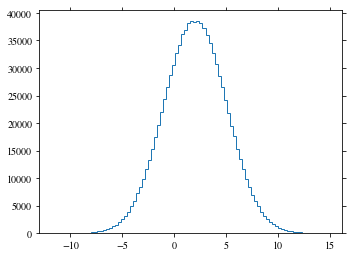

In [5]:
np.random.seed(0)
data = 2 + 3 * randn(int(1e6)) # mu=2, sigma=3
hist(data, bins=100, histtype='step');

In [6]:
%%cython --force
# use --annotate if you wonder what kind of code it generates
cimport cython
import numpy as np
cimport numpy as np  # overwritten those from python with cython
from libc.math cimport exp, M_PI, sqrt, log
from iminuit.util import describe, make_func_code

@cython.embedsignature(True)  # dump the signatre so describe works
cpdef double mypdf(double x, double mu, double sigma):
    #cpdef means generate both c function and python function
    cdef double norm = 1./(sqrt(2*M_PI)*sigma)
    cdef double ret = exp(-1*(x-mu)*(x-mu)/(2.*sigma*sigma))*norm
    return ret

cdef class QuickAndDirtyLogLH:  # cdef is here to reduce name lookup for __call__
    cdef np.ndarray data
    cdef int ndata
    
    def __init__(self, data):
        self.data = data
        self.ndata = len(data)
    
    @cython.embedsignature(True)  # you need this to dump function signature in docstring
    def compute(self, double mu, double sigma):
        #this line is a cast not a copy. Let cython knows mydata will spit out double
        cdef np.ndarray[np.double_t, ndim=1] mydata = self.data
        cdef double loglh = 0.
        cdef double thisdata
        for i in range(self.ndata):
            thisdata = mydata[i]
            loglh -= log(mypdf(mydata[i],mu,sigma))
        return loglh

In [7]:
describe(mypdf)  # works because we embedded the signature

[u'x', u'mu', u'sigma']

In [8]:
lh = QuickAndDirtyLogLH(data)
describe(lh.compute)  # works because we embedded the signature

[u'mu', u'sigma']

In [9]:
m = Minuit(lh.compute, mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1,10.0), errordef=1)
m.migrad();

FCN = 2517472.1448 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 7.32873246079e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,2.00453,0.00424232,,,,,No
1,sigma,2.99977,0.00299978,,,0.1,10,No


In [10]:
%%timeit -n1 -r1
m = Minuit(lh.compute, mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1,10.0),print_level=0, errordef=1)
m.migrad()

1 loop, best of 1: 1.15 s per loop


Have your cython PDF in a separate file
---------------------------------------

Lots of time your stuff is incredibly complicated and doesn't fit in ipython notebook. Or you may want to reuse your PDF in many notebooks. We have external_pdf.pyx in the same directory as this tutorial. This is how you load it.

In [11]:
import pyximport;
pyximport.install(
    setup_args=dict(
        include_dirs=[np.get_include()],#include directory
    #    libraries = ['m']#'stuff you need to link (no -l)
    #    library_dirs ['some/dir']#library dir
    #    extra_compile_args = ['-g','-O2'],
    #    extra_link_args=['-some-link-flags'],
    ),
    reload_support=True,#you may also find this useful
) #if anything funny is going on look at your console
import external_pdf

In [12]:
# reload(external_pdf) #you may find this useful for reloading your module

In [13]:
lh = external_pdf.External_LogLH(data)

In [14]:
m = Minuit(lh.compute,mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1,10.0), errordef=1)
m.migrad();

FCN = 2517472.1448 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 7.32873246079e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,2.00453,0.00424232,,,,,No
1,sigma,2.99977,0.00299978,,,0.1,10,No


In [15]:
%%timeit -r1 -n1 
m = Minuit(lh.compute, mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1,10.0), print_level=0, errordef=1)
m.migrad()

1 loop, best of 1: 1.19 s per loop


### Generic Reusable Cost Function

Sometime we want to write a cost function that will take in any pdf and data and compute appropriate
cost function. This is slower than the previous example but will make your code much more reusable. This is how you do it.

In [16]:
%%cython
# use --annotate if you wonder what kind of code it generates
cimport cython
import numpy as np
cimport numpy as np  # overwritten those from python with cython
from iminuit.util import make_func_code, describe
from libc.math cimport log

cdef class LogLH:  # cdef is here to reduce name lookup for __call__(think of struct)
    cdef np.ndarray data
    cdef int ndata
    cdef public func_code
    cdef object pdf
    
    def __init__(self, pdf, data):
        self.data = data
        self.ndata = len(data)
        #the important line is here
        self.func_code = make_func_code(describe(pdf)[1:])#1: dock off independent param
        self.pdf = pdf
    
    #@cython.boundscheck(False)  # you can turn off bound checking
    def __call__(self, *args):
        cdef np.ndarray[np.double_t, ndim=1] mydata = self.data  # this line is very important
        #with out this line cython will have no idea about data type
        cdef double loglh = 0.
        cdef list larg = [0.]+list(args)
        
        for i in range(self.ndata):
            #it's slower because we need to do so many python stuff
            #to do generic function call
            #if you are python hacker and know how to get around this
            #please let us know
            larg[0] = mydata[i]
            loglh -= log(self.pdf(*larg))
        return loglh

And your favorite PDF

In [17]:
%%cython
#use --annotate if you wonder what kind of code it generates
from libc.math cimport exp, M_PI, sqrt, log
cimport cython

@cython.binding(True)
def mypdf(double x, double mu, double sigma): 
    #cpdef means generate both c function and python function
    cdef double norm = 1./(sqrt(2*M_PI)*sigma)
    cdef double ret = exp(-1*(x-mu)*(x-mu)/(2.*sigma*sigma))*norm
    return ret

In [18]:
mylh = LogLH(mypdf,data)

In [19]:
print(describe(mypdf))
print(describe(mylh))

['x', 'mu', 'sigma']
['mu', 'sigma']


In [20]:
describe(mypdf)

['x', 'mu', 'sigma']

In [21]:
m = Minuit(mylh, mu=1.5, sigma=2.5, error_mu=0.1, 
           error_sigma=0.1, limit_sigma=(0.1,10.0), errordef=1)
# it's slower than before
m.migrad();

FCN = 2517472.1448 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 7.32873246079e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,2.00453,0.00424232,,,,,No
1,sigma,2.99977,0.00299978,,,0.1,10,No


In [22]:
%%timeit -r2 -n1
m=Minuit(mylh, mu=1.5, sigma=2.5, error_mu=0.1, 
         error_sigma=0.1, limit_sigma=(0.1,10.0), print_level=0, errordef=1)
m.migrad() # you can feel it's much slower than before

1 loop, best of 2: 3.75 s per loop


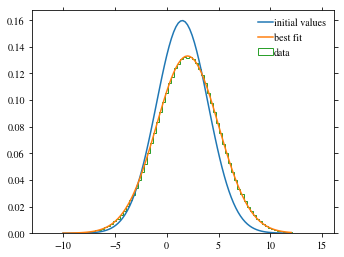

In [23]:
# show histogram of data and fitted pdf
x = linspace(-10,12,100)
initial = np.fromiter((mypdf(xx, 1.5, 2.5) for xx in x), float);
fit = np.fromiter((mypdf(xx, m.values['mu'], m.values['sigma']) for xx in x), float);
plot(x, initial, label='initial values')
plot(x, fit, label='best fit')
hist(data, normed=True, bins=100, histtype='step', label='data')
legend();

### Parallel processing with `multiprocessing`
This example is most likely not working on windows. You need to implement a bunch of workaround for lack of fork() on Windows such that it's easier to install a decent linux on your computer.

The idea here on how to parallelize your cost function is to separate you data into multiple chunks and have each worker calculate your cost function, collect them at the end and add them up.

The tool we will be showing here is Python multiprocess. We will be rewriting our generic cost funciton but now with multiprocessing.

You might be worried about that forking process will copy your data. Most modern OS use [Copy On Write](http://en.wikipedia.org/wiki/Copy-on-write mechanism)(look at wiki)
what this means is that when it forks a process
it doesn't copy memory there unless you are writing it

In [24]:
%%cython -f
cimport cython
import numpy as np
cimport numpy as np #overwritten those from python with cython
from libc.math cimport exp, M_PI, sqrt, log, floor
from libc.stdio cimport printf
from iminuit.util import make_func_code, describe
import multiprocessing as mp
from multiprocessing import Manager
import os
#import logging
#logger = multiprocessing.log_to_stderr()
#don't do this in ipython either it will crash(watch ipython #2438)
#logger.setLevel(multiprocessing.SUBDEBUG)

@cython.embedsignature(True)#dump the signatre so describe works
cpdef double mypdf(double x, double mu, double sigma):
    #cpdef means generate both c function and python function
    cdef double norm
    cdef double ret
    norm = 1./(sqrt(2*M_PI)*sigma)
    ret = exp(-1*(x-mu)*(x-mu)/(2.*sigma*sigma))*norm
    return ret

cdef class Multiprocess_LogLH:#cdef is here to reduce name lookup for __call__
    cdef np.ndarray data
    #cdef double* databuffer#i'm not really sure if numpy will do copy on write only or not
    cdef int ndata
    cdef public func_code
    cdef object pdf
    cdef int njobs
    cdef list starts
    cdef list stops
    cdef object pool
    cdef int i
    cdef object manager
    cdef object results
    def __init__(self, pdf, np.ndarray[np.double_t] data, njobs=None):
        self.data = data
        #self.databuffer = <double*>data.data
        self.ndata = len(data)
        
        #the important line is here
        self.func_code = make_func_code(describe(pdf)[1:])#1: dock off independent param
        self.pdf = pdf
        
        #worker pool stuff
        self.njobs = njobs if njobs is not None else mp.cpu_count()
        print('Number of CPU: ',self.njobs)
        #determine chunk size
        chunk_size = floor(self.ndata/self.njobs)
        self.starts = [i*chunk_size for i in range(self.njobs)]
        self.stops = [(i+1)*chunk_size for i in range(self.njobs)]
        self.stops[-1] = self.ndata #add back last couple data from round off
        self.i = 0
        self.manager = Manager()
        self.results = self.manager.Queue()
    
    @cython.embedsignature(True)
    cpdef process_chunk(self, 
            int pid, int start, int stop, tuple args, object results): #start stop is [start, stop) 
        #be careful here there is a bug in ipython preventing
        #child process from printing to stdout/stderr (you will get a segfault)
        #I submitted a patch https://github.com/ipython/ipython/pull/2712
        #Ex: For now, do something like this if you need to debug
        #msg = str(('Start Worker:', pid, start, stop,os.getpid()))+'\n'
        #printf(msg)
        #it will run fine as a python script though
        cdef np.ndarray[np.double_t, ndim=1] mydata = self.data # get cython to know the type
        cdef int i
        cdef double loglh = 0.
        cdef double tmp = 0.
        cdef tuple t
        #calculate lh for this chunk
        cdef list larg = [0.]+list(args)
        for i in range(start,stop):
            tmp = mydata[i]
            larg[0] = tmp
            loglh -= log(self.pdf(*larg))
        results.put(loglh) #put result in multiprocessing.queue
        return loglh#return isn't necessary since it will be ignored but useful for testing

    def __call__(self, *args):
        cdef double ret=0
        pool = [mp.Process(target=self.process_chunk,
                           args=(i,self.starts[i],self.stops[i],args,self.results)) 
                    for i in range(self.njobs)]
        # you may think that forking this many time is inefficient
        # We can do better but this is not bad. Since most of the time
        # will be spend on calculating your loglh this is cheap compared to those.
        # If forking is more expensive than what each worker does then... 
        # your problem is something else.
        # Copy on write ensures that data points will never be copied (unless you write to it)
        self.i+=1
        for p in pool: p.start() #start everyone
        for p in pool: p.join() #wait for everyone to finish
        while not self.results.empty(): #collect the result
            tmp = self.results.get()
            ret += tmp
        return ret

In [25]:
mlh = Multiprocess_LogLH(mypdf,data)

('Number of CPU: ', 4)


In [26]:
#good idea to debug it in non-multiprocess environment first
import multiprocessing as mp
q = mp.Queue()
mlh.process_chunk(0, 0, 10, (0,1), q)

140.06719362225851

In [27]:
#then see if it works on one point
mlh(0, 1)

7427313.663942839

In [28]:
m = Minuit(mlh,mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1, 10.0), errordef=1)
m.migrad();

FCN = 2517472.1448 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 7.33094246443e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,2.00453,0.00424232,,,,,No
1,sigma,2.99977,0.00299978,,,0.1,10,No


In [29]:
%%timeit -r1 -n1
m = Minuit(mlh,mu=1.5, sigma=2.5, error_mu=0.1, 
           error_sigma=0.1, limit_sigma=(0.1, 10.0), print_level=0, errordef=1)
m.migrad()

1 loop, best of 1: 3.68 s per loop


### Parallel Computing With Cython and OpenMP
*For this tutorial you will need a compiler with openmp support. GCC has one. However, clang does NOT support it.*

**This is not recommended. Do this only when overhead of multiprocessing is too big for you. The performance gain is probably not worth your headache.**

Computer nowadays are multi-core machines so it makes sense to utilize all of them. This method is fast but quite restricted and cubersome since you need to write function such that cython can figure out its reentrant-ness. And you need some understanding of thread-local and thread-share variable.

You can read [prange](http://wiki.cython.org/enhancements/prange) from cython wiki for more information and how to gain a more complete control over paralelization. The official documentation is [here](http://docs.cython.org/src/userguide/parallelism.html)

In [30]:
%%cython -f -c-fopenmp --link-args=-fopenmp -c-g
# use --annotate if you wonder what kind of code it generates
cimport cython
import numpy as np
cimport numpy as np #overwritten those from python with cython
from libc.math cimport exp, M_PI, sqrt, log
from iminuit.util import describe, make_func_code
import multiprocessing
from cython.parallel import prange


# notice nogil a the end (no global intepreter lock)
# cython doesn't do a super thorough check for this
# so make sure your function is reentrant this means approximately 
# just simple function compute simple stuff based on local stuff and no read/write to global 
@cython.embedsignature(True)#dump the signatre so describe works
@cython.cdivision(True)
cpdef double mypdf(double x, double mu, double sigma) nogil:
    #cpdef means generate both c function and python function
    cdef double norm
    cdef double ret
    norm = 1./(sqrt(2*M_PI)*sigma)
    ret = exp(-1*(x-mu)*(x-mu)/(2.*sigma*sigma))*norm
    return ret

cdef class ParallelLogLH:#cdef is here to reduce name lookup for __call__
    cdef np.ndarray data
    cdef int ndata
    cdef int njobs
    cdef np.ndarray buf#buffer for storing result from each job
    def __init__(self, data, njobs=None):
        self.data = data
        self.ndata = len(data)
        self.njobs = njobs if njobs is not None else multiprocessing.cpu_count()
        print('Number of CPU: ',self.njobs)
    
    @cython.boundscheck(False)
    @cython.embedsignature(True)#you need this to dump function signature in docstring
    def compute(self, double mu, double sigma):
        cdef np.ndarray[np.double_t, ndim=1] mydata = self.data
        cdef double loglh = 0.
        cdef tuple t
        cdef double thisdata
        cdef int i=0
        #in parallel computing you need to be careful which variable is
        #thread private which variable is shared between thread
        #otherwise you will get into hard to detect racing condition
        #cython rule of thumb(guess rule) is
        # 1) assigned before use is thread private
        # 2) read-only is thread-shared
        # 3) inplace modification only is thread shared
        cdef int njobs = self.njobs
        cdef double tmp
        with nogil:
            for i in prange(self.ndata, 
                            num_threads=njobs, 
                            chunksize=100000, 
                            schedule='dynamic'):#split into many threads
                thisdata = mydata[i] #this is assigned before read so it's thread private
                tmp  = mypdf(thisdata,mu,sigma) #also here assigne before read
                loglh -= log(tmp) #inplace modification so loglh is thread shared
        return loglh

CompileError: command 'cc' failed with exit status 1

In [ ]:
plh = ParallelLogLH(data)

In [ ]:
plh.compute(1.5, 2.0)

In [ ]:
describe(plh.compute)

In [ ]:
m = Minuit(plh.compute,mu=1.5, sigma=2.5, error_mu=0.1, 
           error_sigma=0.1, limit_sigma=(0.1,10.0),print_level=0)
m.migrad();

In [ ]:
%%timeit -n2 -r2
m=Minuit(plh.compute,mu=1.5, sigma=2.5, error_mu=0.1, 
    error_sigma=0.1, limit_sigma=(0.1,10.0),print_level=0)
m.migrad()

### OpenCL
**Want to do fitting using parallel GPU core? If you have multicore GPU Cluster/Machine figure out how to do it and let me know.**

I don't have the machine with such capability so I never bother....Interested in buying one for me? :P